Epoch 1/5
582/582 ━━━━━━━━━━━━━━━━━━━━ 469s 794ms/step - accuracy: 0.9267 - loss: 0.1682 - val_accuracy: 0.9755 - val_loss: 0.0672
Epoch 2/5
582/582 ━━━━━━━━━━━━━━━━━━━━ 469s 805ms/step - accuracy: 0.9803 - loss: 0.0569 - val_accuracy: 0.9785 - val_loss: 0.0589
Epoch 3/5
582/582 ━━━━━━━━━━━━━━━━━━━━ 507s 813ms/step - accuracy: 0.9820 - loss: 0.0508 - val_accuracy: 0.9774 - val_loss: 0.0598
Epoch 4/5
582/582 ━━━━━━━━━━━━━━━━━━━━ 454s 732ms/step - accuracy: 0.9835 - loss: 0.0482 - val_accuracy: 0.9729 - val_loss: 0.0711
Epoch 5/5
582/582 ━━━━━━━━━━━━━━━━━━━━ 434s 717ms/step - accuracy: 0.9851 - loss: 0.0434 - val_accuracy: 0.9796 - val_loss: 0.0565
146/146 ━━━━━━━━━━━━━━━━━━━━ 99s 555ms/step - accuracy: 0.9792 - loss: 0.0575
Acurácia: 97.96%


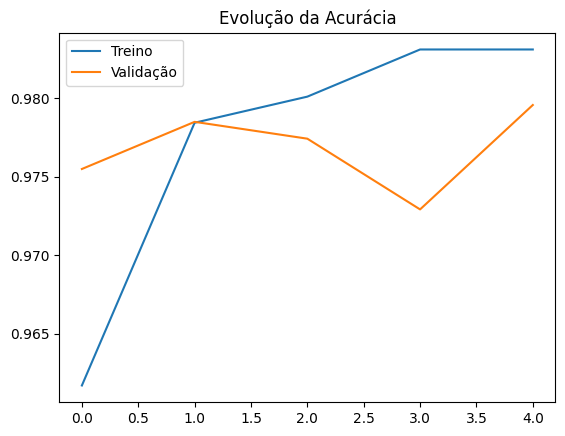

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

# 1. Carregar dataset (somente split "train")
dataset, info = tfds.load('cats_vs_dogs', with_info=True, as_supervised=True)
full_ds = dataset['train']

# 2. Dividir dataset em treino (80%) e teste (20%)
train_size = int(0.8 * info.splits['train'].num_examples)
test_size = int(0.2 * info.splits['train'].num_examples)

train_ds = full_ds.take(train_size)
test_ds = full_ds.skip(train_size)

# 3. Pré-processamento
IMG_SIZE = 160

def format_image(image, label):
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    image = image / 255.0
    return image, label

train_batches = (
    train_ds
    .shuffle(1000)
    .map(format_image)
    .batch(32)
    .prefetch(tf.data.AUTOTUNE)
)

test_batches = (
    test_ds
    .map(format_image)
    .batch(32)
    .prefetch(tf.data.AUTOTUNE)
)

# 4. Modelo base pré-treinado
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False

# 5. Modelo final
global_avg = tf.keras.layers.GlobalAveragePooling2D()
output_layer = tf.keras.layers.Dense(1, activation='sigmoid')

model = tf.keras.Sequential([
    base_model,
    global_avg,
    output_layer
])

# 6. Compilar
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# 7. Treinar
history = model.fit(
    train_batches,
    validation_data=test_batches,
    epochs=5
)

# 8. Avaliar
loss, acc = model.evaluate(test_batches)
print(f"Acurácia: {acc*100:.2f}%")

# 9. Plotar evolução da acurácia
plt.plot(history.history['accuracy'], label='Treino')
plt.plot(history.history['val_accuracy'], label='Validação')
plt.legend()
plt.title("Evolução da Acurácia")
plt.show()

# 10. Salvar modelo treinado
model.save("transfer_learning_cats_vs_dogs.h5")